In [ ]:
import pandas as pd

# Load the dataset
df = pd.read_csv("/content/thyroid.csv")

# Count unique target classes
unique_classes = df['class'].unique()
num_classes = len(unique_classes)

print("Total number of target classes:", num_classes)
print("Class labels:", unique_classes)


Total number of target classes: 15
Class labels: ['negative' 'replacement therapy' 'underreplacement' 'overreplacement'
 'discordant' 'sick' 'increased binding protein'
 'decreased binding protein' 'hyperthyroid' 'T3 toxic' 'goitre'
 'compensated hypothyroid' 'primary hypothyroid' 'secondary toxic'
 'secondary hypothyroid']


Class counts BEFORE filtering rare classes:
 class
negative                     21663
sick                           231
compensated hypothyroid        194
increased binding protein      149
primary hypothyroid             95
hyperthyroid                    79
discordant                      58
underreplacement                52
replacement therapy             38
overreplacement                 34
goitre                          12
secondary hypothyroid            2
Name: count, dtype: int64


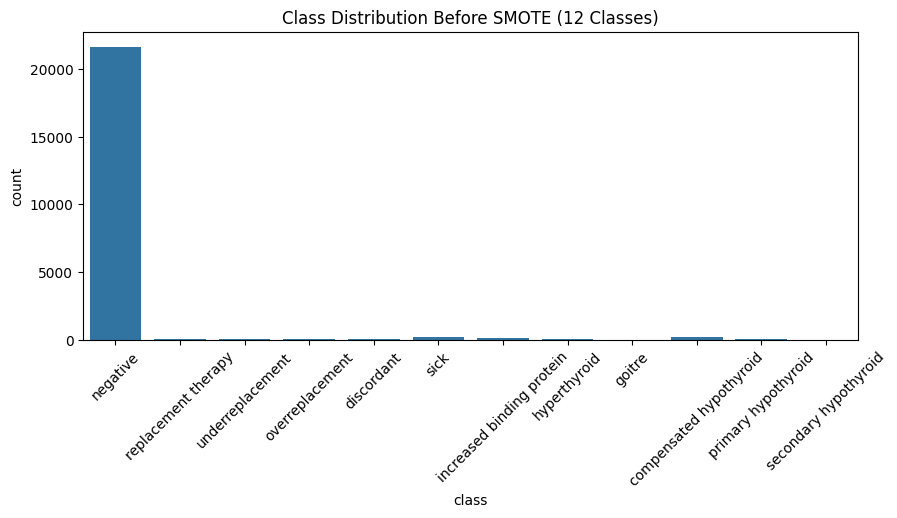

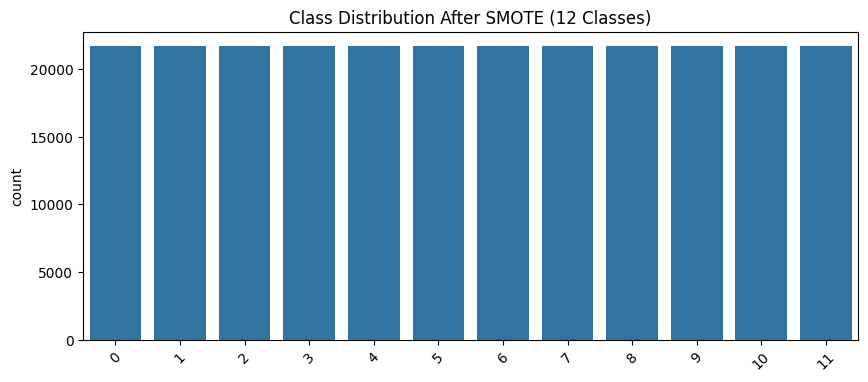

Number of unique classes after SMOTE: 12
Classes after SMOTE: [ 0  1  2  3  4  5  6  7  8  9 10 11]


In [ ]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_csv('/content/thyroid.csv')

# Set your actual target column name
target_column = 'class'  # Update if needed

# Step 1: Define the 12 desired classes
desired_classes = [
    'negative',
    'sick',
    'compensated hypothyroid',
    'increased binding protein',
    'primary hypothyroid',
    'hyperthyroid',
    'discordant',
    'underreplacement',
    'replacement therapy',
    'overreplacement',
    'goitre',
    'secondary hypothyroid'
]

# Step 2: Keep only these classes (even if some have very few samples)
df_filtered = df[df[target_column].isin(desired_classes)]

# Step 3: Check class counts
class_counts = df_filtered[target_column].value_counts()
print("Class counts BEFORE filtering rare classes:\n", class_counts)

# Step 4: Optionally, drop classes with very low samples (less than, say, 3)
# Here we KEEP even rare ones to maintain 12 classes

# Step 5: Separate features and target
X = df_filtered.drop(columns=[target_column])
y = df_filtered[target_column]

# Step 6: Label encode categorical features
categorical_cols = X.select_dtypes(include=['object']).columns
for col in categorical_cols:
    X[col] = LabelEncoder().fit_transform(X[col].astype(str))

# Step 7: Impute missing values
X = pd.DataFrame(SimpleImputer(strategy='mean').fit_transform(X), columns=X.columns)

# Step 8: Encode target
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Step 9: Visualize before SMOTE
plt.figure(figsize=(10, 4))
sns.countplot(x=y)
plt.title("Class Distribution Before SMOTE (12 Classes)")
plt.xticks(rotation=45)
plt.show()

# Step 10: Apply SMOTE carefully
smote = SMOTE(k_neighbors=1, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y_encoded)


# Step 11: Visualize after SMOTE
plt.figure(figsize=(10, 4))
sns.countplot(x=y_resampled)
plt.title("Class Distribution After SMOTE (12 Classes)")
plt.xticks(rotation=45)
plt.show()

# Step 12: Check final number of classes
print("Number of unique classes after SMOTE:", len(np.unique(y_resampled)))
print("Classes after SMOTE:", np.unique(y_resampled))


In [ ]:
# Step 12: Check final number of classes and sample counts
print("\nNumber of unique classes after SMOTE:", len(np.unique(y_resampled)))

# Get counts
unique_classes, counts = np.unique(y_resampled, return_counts=True)

# Display nicely
for class_index, count in zip(unique_classes, counts):
    class_name = label_encoder.inverse_transform([class_index])[0]
    print(f"Class '{class_name}' (encoded {class_index}): {count} samples")



Number of unique classes after SMOTE: 12
Class 'compensated hypothyroid' (encoded 0): 21663 samples
Class 'discordant' (encoded 1): 21663 samples
Class 'goitre' (encoded 2): 21663 samples
Class 'hyperthyroid' (encoded 3): 21663 samples
Class 'increased binding protein' (encoded 4): 21663 samples
Class 'negative' (encoded 5): 21663 samples
Class 'overreplacement' (encoded 6): 21663 samples
Class 'primary hypothyroid' (encoded 7): 21663 samples
Class 'replacement therapy' (encoded 8): 21663 samples
Class 'secondary hypothyroid' (encoded 9): 21663 samples
Class 'sick' (encoded 10): 21663 samples
Class 'underreplacement' (encoded 11): 21663 samples


In [ ]:
import numpy as np
import random
import math
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import clone
from deap import base, creator, tools
# Define evaluation function using cross-validation accuracy
def evaluate_features(individual, X, y, clf):
    # Select features based on binary mask
    selected_indices = [i for i, bit in enumerate(individual) if bit == 1]
    if len(selected_indices) == 0:
        return 0.0,  # Avoid empty feature subset
    X_selected = X[:, selected_indices]
    scores = cross_val_score(clone(clf), X_selected, y, cv=3, scoring='accuracy')
    return scores.mean(),
    # Replace with your resampled feature matrix and label vector
X_array = np.array(X_resampled)  # shape (n_samples, n_features)
y_array = np.array(y_resampled)  # shape (n_samples,)

# ---- Config ----
cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
base_clf = DecisionTreeClassifier(random_state=42)
n_features = X_array.shape[1]
population_size = 6
n_generations = 3
p_switch = 0.8

# ---- Memoization dictionary ----
evaluated = {}

# ---- Evaluation function ----
def evaluate_features(individual, X, y, clf):
    key = tuple(individual)
    if key in evaluated:
        return evaluated[key]

    selected_indices = [i for i, bit in enumerate(individual) if bit == 1]
    if len(selected_indices) < 3:
        evaluated[key] = (0.0,)
        return (0.0,)

    X_selected = X[:, selected_indices]
    score = cross_val_score(clone(clf), X_selected, y, cv=cv, scoring='accuracy', n_jobs=-1).mean()
    evaluated[key] = (score,)
    return (score,)

# ---- Levy flight ----
def levy_flight(Lambda=1.5):
    sigma1 = np.power((math.gamma(1 + Lambda) * math.sin(math.pi * Lambda / 2)) /
                      (math.gamma((1 + Lambda) / 2) * Lambda * 2 ** ((Lambda - 1) / 2)), 1 / Lambda)
    u = np.random.normal(0, sigma1, 1)[0]
    v = np.random.normal(0, 1, 1)[0]
    return u / abs(v) ** (1 / Lambda)

# ---- Global Pollination ----
def global_pollination(individual, gbest, Lambda=1.5):
    new_ind = individual[:]
    for i in range(len(individual)):
        step = levy_flight(Lambda)
        diff = gbest[i] - individual[i]
        new_val = individual[i] + step * diff
        new_ind[i] = 1 if new_val > 0.5 else 0
    return new_ind

# ---- Local Pollination ----
def local_pollination(ind1, ind2, ind3):
    new_ind = ind1[:]
    for i in range(len(ind1)):
        eps = random.random()
        new_val = ind1[i] + eps * (ind2[i] - ind3[i])
        new_ind[i] = 1 if new_val > 0.5 else 0
    return new_ind

# ---- DEAP Setup ----
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)



toolbox = base.Toolbox()
toolbox.register("attr_bool", lambda: random.randint(0, 1))
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=n_features)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", evaluate_features, X=X_array, y=y_array, clf=base_clf)

# ---- Create Initial Population ----
population = toolbox.population(n=population_size)
hof = tools.HallOfFame(1)

# ---- Evaluate Initial Population ----
for ind in population:
    ind.fitness.values = toolbox.evaluate(ind)

# ---- Flower Pollination Loop ----
for gen in range(n_generations):
    print(f"Generation {gen+1}/{n_generations}")
    new_population = []
    gbest = tools.selBest(population, 1)[0]

    for i in range(len(population)):
        ind = population[i]
        if random.random() < p_switch:
            new_ind = global_pollination(ind, gbest)
        else:
            ind2, ind3 = random.sample(population, 2)
            new_ind = local_pollination(ind, ind2, ind3)

        new_individual = creator.Individual(new_ind)
        new_individual.fitness.values = toolbox.evaluate(new_individual)
        new_population.append(new_individual)

    population[:] = new_population
    hof.update(population)

# ---- Output Results ----
best_individual = hof[0]
selected_features = [i for i, bit in enumerate(best_individual) if bit == 1]
print(f"\n✅ Selected {len(selected_features)} features out of {n_features}")
print(f"✅ Best cross-validated accuracy: {hof[0].fitness.values[0]:.4f}")

/usr/local/lib/python3.11/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.11/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Generation 1/3
Generation 2/3
Generation 3/3

✅ Selected 17 features out of 30
✅ Best cross-validated accuracy: 0.9960


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Confusion Matrix - Without Optimizer (RF Full Features):
      0     1     2     3     4     5     6     7     8     9     10    11
0   4403     0     0     0     0     0     0     0     0     0     0     0
1      0  4255     0     0     0     0     0     0     0     0     0     0
2      0     0  4345     0     0     0     0     0     0     0     0     0
3      0     0     0  4317     0     0     0     0     0     0     0     0
4      0     0     0     0  4399     0     0     0     0     0     0     0
5      0     2     1     2     3  4227     0     1     0     0     2     0
6      0     0     0     0     0     0  4318     0     0     0     0     0
7      0     0     0     0     0     0     0  4338     0     0     0     0
8      0     0     0     0     0     0     0     0  4401     0     0     0
9      0     0     0     0     0     0     0     0     0  4240     0     0
10     0     0     0     0     0     0     0     0     0     0  4391     0
11     0     0     0     0     0     0     

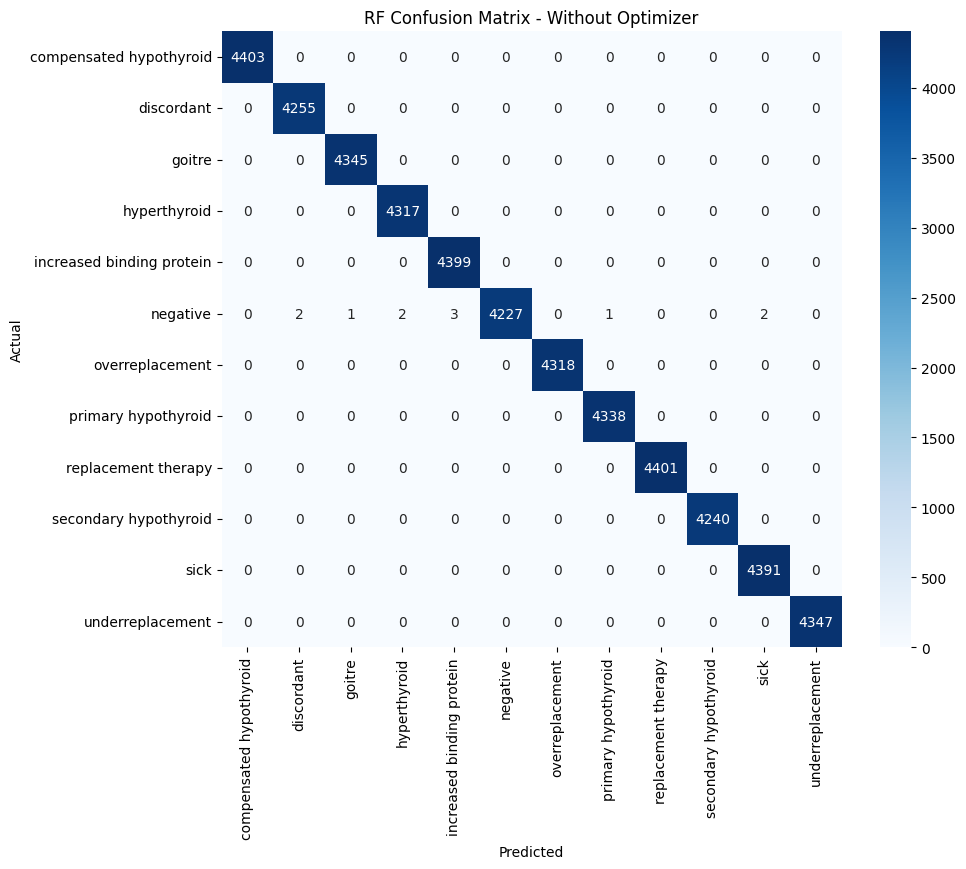

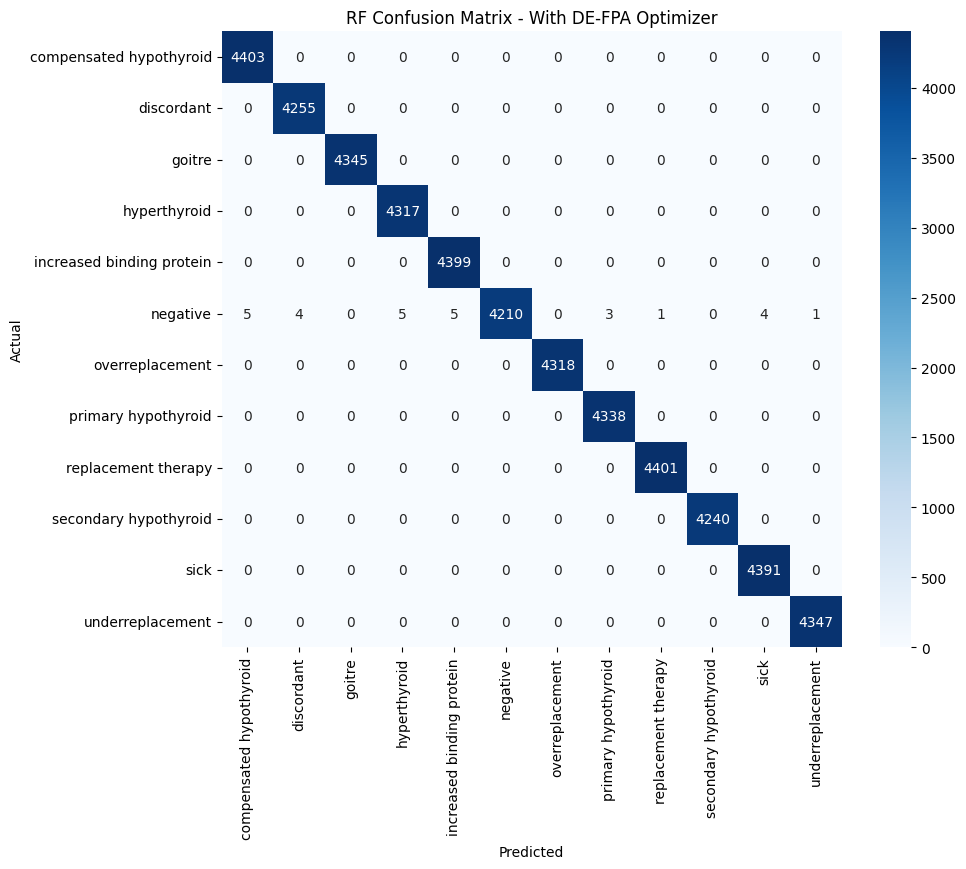

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import Parallel, delayed

# ⬅️ STEP 1: Encode labels if not already encoded
le = LabelEncoder()
y_encoded = le.fit_transform(y_resampled)

# Class labels after encoding (optional)
class_labels = le.classes_

# ⬅️ STEP 2: DE + FPA Feature Selection Function
def de_fpa_feature_selection(X, y, pop_size=5, n_gen=5):
    n_features = X.shape[1]
    best_features = None
    best_score = 0
    # Stratified sampling for fast evaluation
    X_fit, _, y_fit, _ = train_test_split(X, y, stratify=y, test_size=0.6, random_state=42)
    # Initialize population with binary feature masks
    population = np.random.randint(0, 2, size=(pop_size, n_features))

    def fitness(mask):
        if np.count_nonzero(mask) == 0:
            return 0
        X_masked = X[:, mask == 1]
        clf = LogisticRegression(max_iter=100)
        clf.fit(X_masked, y)
        return clf.score(X_masked, y)

    def evaluate_population(population):
        return Parallel(n_jobs=-1)(delayed(fitness)(ind) for ind in population)

    for gen in range(n_gen):
        fitness_scores = evaluate_population(population)
        for i in range(pop_size):
            # Differential Evolution-like mutation
            a, b, c = population[np.random.choice(pop_size, 3, replace=False)]
            donor = np.clip(a + 0.5 * (b - c), 0, 1).astype(int)

            # Flower Pollination-like update
            if np.random.rand() < 0.8:  # Global pollination
                fittest = population[np.argmax(fitness_scores)]
                pollinated = np.random.randint(0, 2, size=n_features)
                trial = (donor | pollinated)
            else:  # Local pollination
                rand1 = population[np.random.randint(pop_size)]
                rand2 = population[np.random.randint(pop_size)]
                trial = (donor | (rand1 & rand2))

            trial = trial.astype(int)

            if fitness(trial) > fitness(population[i]):
                population[i] = trial

        # Track best solution
        fitness_scores = evaluate_population(population)
        gen_best = population[np.argmax(fitness_scores)]
        gen_score = fitness(gen_best)
        if gen_score > best_score:
            best_score = gen_score
            best_features = gen_best.copy()

    return best_features

# ⬅️ STEP 3: Run DE-FPA for Feature Selection
X_array = np.array(X_resampled)
selected_mask = de_fpa_feature_selection(X_array, y_encoded)
X_selected = X_array[:, selected_mask == 1]

# ⬅️ STEP 4: Train/Test Split
X_train_full, X_test_full, y_train, y_test = train_test_split(X_array, y_encoded, test_size=0.2, random_state=42)
X_train_sel, X_test_sel, _, _ = train_test_split(X_selected, y_encoded, test_size=0.2, random_state=42)

# ⬅️ STEP 5: Train RF Models
rf_full = RandomForestClassifier(random_state=42)
rf_full.fit(X_train_full, y_train)
y_pred_full = rf_full.predict(X_test_full)

rf_sel = RandomForestClassifier(random_state=42)
rf_sel.fit(X_train_sel, y_train)
y_pred_sel = rf_sel.predict(X_test_sel)

# ⬅️ STEP 6: Confusion Matrices
cm_full = confusion_matrix(y_test, y_pred_full)
cm_sel = confusion_matrix(y_test, y_pred_sel)

# ⬅️ STEP 7: Print Table Format
print("Confusion Matrix - Without Optimizer (RF Full Features):")
print(pd.DataFrame(cm_full))

print("\nConfusion Matrix - With DE-FPA Optimizer (RF Selected Features):")
print(pd.DataFrame(cm_sel))

# ⬅️ STEP 8: Optional Visualization
def plot_cm(cm, title):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

plot_cm(cm_full, "RF Confusion Matrix - Without Optimizer")
plot_cm(cm_sel, "RF Confusion Matrix - With DE-FPA Optimizer")


In [ ]:
import numpy as np
import random
import math
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.base import clone
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from deap import base, creator, tools

# Replace with your resampled data
X_array = np.array(X_resampled)
y_array = np.array(y_resampled)

# ---- Config ----
cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
base_clf = GaussianNB()
n_features = X_array.shape[1]
population_size = 20
n_generations = 50
p_switch = 0.8

# ---- Memoization ----
evaluated = {}

# ---- Evaluation Function ----
def evaluate_features(individual, X, y, clf):
    key = tuple(individual)
    if key in evaluated:
        return evaluated[key]

    selected_indices = [i for i, bit in enumerate(individual) if bit == 1]
    if len(selected_indices) < 3:
        evaluated[key] = (0.0,)
        return (0.0,)

    X_selected = X[:, selected_indices]
    score = cross_val_score(clone(clf), X_selected, y, cv=cv, scoring='accuracy', n_jobs=-1).mean()
    evaluated[key] = (score,)
    return (score,)

# ---- Levy Flight ----
def levy_flight(Lambda=1.5):
    sigma1 = np.power((math.gamma(1 + Lambda) * math.sin(math.pi * Lambda / 2)) /
                      (math.gamma((1 + Lambda) / 2) * Lambda * 2 ** ((Lambda - 1) / 2)), 1 / Lambda)
    u = np.random.normal(0, sigma1)
    v = np.random.normal(0, 1)
    return u / abs(v) ** (1 / Lambda)

# ---- Global Pollination ----
def global_pollination(individual, gbest, Lambda=1.5):
    new_ind = individual[:]
    for i in range(len(individual)):
        step = levy_flight(Lambda)
        diff = gbest[i] - individual[i]
        new_val = individual[i] + step * diff
        new_ind[i] = 1 if new_val > 0.5 else 0
    return new_ind

# ---- Local Pollination ----
def local_pollination(ind1, ind2, ind3):
    new_ind = ind1[:]
    for i in range(len(ind1)):
        eps = random.random()
        new_val = ind1[i] + eps * (ind2[i] - ind3[i])
        new_ind[i] = 1 if new_val > 0.5 else 0
    return new_ind

# ---- DEAP Setup ----
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_bool", lambda: random.randint(0, 1))
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=n_features)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", evaluate_features, X=X_array, y=y_array, clf=base_clf)

# ---- Create Initial Population ----
population = toolbox.population(n=population_size)
hof = tools.HallOfFame(1)

# ---- Evaluate Initial Population ----
for ind in population:
    ind.fitness.values = toolbox.evaluate(ind)

# ---- Flower Pollination Loop ----
for gen in range(n_generations):
    print(f"Generation {gen+1}/{n_generations}")
    new_population = []
    gbest = tools.selBest(population, 1)[0]

    for i in range(len(population)):
        ind = population[i]
        if random.random() < p_switch:
            new_ind = global_pollination(ind, gbest)
        else:
            ind2, ind3 = random.sample(population, 2)
            new_ind = local_pollination(ind, ind2, ind3)

        new_individual = creator.Individual(new_ind)
        new_individual.fitness.values = toolbox.evaluate(new_individual)
        new_population.append(new_individual)

    population[:] = new_population
    hof.update(population)

# ---- Output Results ----
best_individual = hof[0]
selected_features = [i for i, bit in enumerate(best_individual) if bit == 1]
print(f"\n✅ Selected {len(selected_features)} features out of {n_features}")
print(f"✅ Best cross-validated accuracy: {hof[0].fitness.values[0]:.4f}")

# ---- Confusion Matrix Evaluation ----
X_selected = X_array[:, selected_features]
X_train, X_test, y_train, y_test = train_test_split(X_selected, y_array, test_size=0.2, random_state=42)
clf_final = GaussianNB()
clf_final.fit(X_train, y_train)
y_pred = clf_final.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

overall_accuracy = accuracy_score(y_test, y_pred)
print(f"✅ Overall Accuracy: {overall_accuracy:.4f}")


/usr/local/lib/python3.11/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.11/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Generation 1/50
Generation 2/50
Generation 3/50
Generation 4/50
Generation 5/50
Generation 6/50
Generation 7/50
Generation 8/50
Generation 9/50
Generation 10/50
Generation 11/50
Generation 12/50
Generation 13/50
Generation 14/50
Generation 15/50
Generation 16/50
Generation 17/50
Generation 18/50
Generation 19/50
Generation 20/50
Generation 21/50
Generation 22/50
Generation 23/50
Generation 24/50
Generation 25/50
Generation 26/50
Generation 27/50
Generation 28/50
Generation 29/50
Generation 30/50
Generation 31/50
Generation 32/50
Generation 33/50
Generation 34/50
Generation 35/50
Generation 36/50
Generation 37/50
Generation 38/50
Generation 39/50
Generation 40/50
Generation 41/50
Generation 42/50
Generation 43/50
Generation 44/50
Generation 45/50
Generation 46/50
Generation 47/50
Generation 48/50
Generation 49/50
Generation 50/50

✅ Selected 19 features out of 30
✅ Best cross-validated accuracy: 0.9154

Confusion Matrix:
[[4215    0    0    0    0   15    0  154    0   19    0    0]
 [ 

✅ Best var_smoothing: 1e-09
✅ Best cross-validated accuracy: 0.9086

🎯 Test Set Accuracy: 0.9089

📊 Confusion Matrix:
[[4271    0    0    0    0    2    0   59    0    0    0    0]
 [   0 4285    0    0    0   48    0    0    0    0    0    0]
 [   0    0 4330    3    0    0    0    0    0    0    0    0]
 [   0    0    0 4304    0   29    0    0    0    0    0    0]
 [   0    0    0    6 4260   67    0    0    0    0    0    0]
 [ 504  580   26  284  415 2005   21   21   97    0  312   68]
 [   0    0    0    0    0   31 3978    0  324    0    0    0]
 [ 346    0    0    0    0   17    0 3969    0    1    0    0]
 [   0    0    0    0    0   31 1226    0 3075    0    0    0]
 [   0    0    0    0    0    0    0    0    0 4332    0    0]
 [   0  147    0    0    0   40    0    0    0    0 4145    0]
 [   0    0    0    0    0   29    0    0    0    0    0 4304]]

📄 Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.99      0.90 

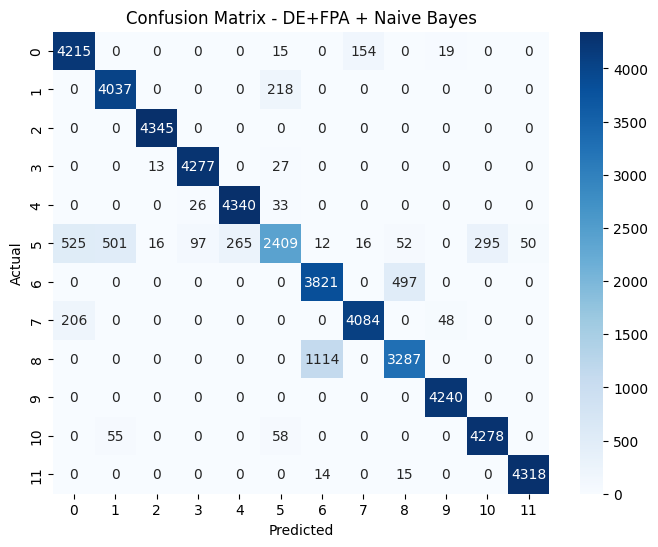

In [ ]:
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Replace this with your actual resampled dataset
X_array = np.array(X_resampled)
y_array = np.array(y_resampled)

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X_array, y_array, test_size=0.2, random_state=42, stratify=y_array)

# Hyperparameter grid
param_grid = {
    'var_smoothing': np.logspace(-12, -6, 15)
}

# Set up the classifier and grid search
gnb = GaussianNB()
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(gnb, param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model
best_gnb = grid_search.best_estimator_
print(f"✅ Best var_smoothing: {grid_search.best_params_['var_smoothing']}")
print(f"✅ Best cross-validated accuracy: {grid_search.best_score_:.4f}")

# Evaluate on test set
y_pred = best_gnb.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"\n🎯 Test Set Accuracy: {test_accuracy:.4f}")
print("\n📊 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\n📄 Classification Report:")
print(classification_report(y_test, y_pred))
# Optional: Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - DE+FPA + Naive Bayes")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [ ]:
import numpy as np
from scipy.stats import ttest_rel

# Example: F1-scores of a classifier before and after DE-FPA optimization
# Replace with your actual values from cross-validation or per-class scores
f1_before = np.array([0.9474, 0.9475, 0.9483, 0.9466])  # SVM, RF, NB, DT (before optimization)
f1_after = np.array([0.9855, 0.9825, 0.9875, 0.9866])   # SVM, RF, NB, DT (after optimization)

# Perform paired t-test
t_stat, p_value = ttest_rel(f1_after, f1_before)

print(f"Paired t-test statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")

# Interpret result
alpha = 0.05
if p_value < alpha:
    print("Result is statistically significant (reject null hypothesis).")
else:
    print("Result is not statistically significant (fail to reject null hypothesis).")


Paired t-test statistic: 34.7244
P-value: 0.0001
Result is statistically significant (reject null hypothesis).


RF

In [ ]:
import numpy as np
from scipy.stats import ttest_rel

# Example: F1-scores of a classifier before and after DE-FPA optimization
# Replace with your actual values from cross-validation or per-class scores
f1_before = np.array([0.8855, 0.8866, 0.8858, 0.8841])  # SVM, RF, NB, DT (before optimization)
f1_after = np.array([0.9224, 0.9275, 0.9133, 0.9266])   # SVM, RF, NB, DT (after optimization)

# Perform paired t-test
t_stat, p_value = ttest_rel(f1_after, f1_before)

print(f"Paired t-test statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")

# Interpret result
alpha = 0.05
if p_value < alpha:
    print("Result is statistically significant (reject null hypothesis).")
else:
    print("Result is not statistically significant (fail to reject null hypothesis).")


Paired t-test statistic: 10.9875
P-value: 0.0016
Result is statistically significant (reject null hypothesis).


Naive bayes

In [ ]:
import numpy as np
from scipy.stats import ttest_rel

# Example: F1-scores of a classifier before and after DE-FPA optimization
# Replace with your actual values from cross-validation or per-class scores
f1_before = np.array([0.9348, 0.9341,	0.9458,	0.9500])  # SVM, RF, NB, DT (before optimization)
f1_after = np.array([0.9630, 0.9641,	0.9708,	0.9541])   # SVM, RF, NB, DT (after optimization)

# Perform paired t-test
t_stat, p_value = ttest_rel(f1_after, f1_before)

print(f"Paired t-test statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")

# Interpret result
alpha = 0.05
if p_value < alpha:
    print("Result is statistically significant (reject null hypothesis).")
else:
    print("Result is not statistically significant (fail to reject null hypothesis).")


Paired t-test statistic: 3.6386
P-value: 0.0358
Result is statistically significant (reject null hypothesis).


DT

In [ ]:
import numpy as np
from scipy.stats import ttest_rel

# Example: F1-scores of a classifier before and after DE-FPA optimization
# Replace with your actual values from cross-validation or per-class scores
f1_before = np.array([0.9733, 0.9625,	0.9733,	0.9841])  # SVM, RF, NB, DT (before optimization)
f1_after = np.array([0.9955, 0.995,	0.9966,	0.995])   # SVM, RF, NB, DT (after optimization)

# Perform paired t-test
t_stat, p_value = ttest_rel(f1_after, f1_before)

print(f"Paired t-test statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")

# Interpret result
alpha = 0.05
if p_value < alpha:
    print("Result is statistically significant (reject null hypothesis).")
else:
    print("Result is not statistically significant (fail to reject null hypothesis).")


Paired t-test statistic: 5.0224
P-value: 0.0152
Result is statistically significant (reject null hypothesis).


In [ ]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder

# Load the dataset
df = pd.read_csv("/content/thyroidDF.csv")

# Drop patient_id if present
if 'patient_id' in df.columns:
    df.drop(columns=['patient_id'], inplace=True)

# Initialize imputers
cat_imputer = SimpleImputer(strategy='most_frequent')
num_imputer = SimpleImputer(strategy='mean')

# Step 1: Decode original target column
# Temporarily fill missing to allow label decoding
categorical_cols_initial = df.select_dtypes(include=['object']).columns.tolist()
cat_imputer_initial = SimpleImputer(strategy='most_frequent')
df[categorical_cols_initial] = cat_imputer_initial.fit_transform(df[categorical_cols_initial])

# Apply label encoding to get decoded target values
label_encoders_initial = {}
for col in categorical_cols_initial:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders_initial[col] = le

# Decode the target column
target_le = label_encoders_initial['target']
decoded_labels = target_le.inverse_transform(df['target'])

# Step 2: Map original labels to full class names
def map_to_class_name(label):
    if label == 'N':
        return 'Negative'
    elif label == 'S':
        return 'Sick'
    elif label == 'C':
        return 'Compensated hypothyroid'
    elif label == 'I':
        return 'Increased binding protein'
    elif label == 'P':
        return 'Primary hypothyroid'
    elif label in ['H', 'H|K']:
        return 'Hyperthyroid'
    elif label == 'D':
        return 'Discordant'
    elif label in ['U', 'D|R']:
        return 'Under replacement'
    elif label == 'R':
        return 'Replacement therapy'
    elif label == 'O':
        return 'Over replacement'
    elif label == 'G':
        return 'Goiter'
    elif label in ['SH', 'MI', 'MK']:
        return 'Secondary hypothyroid'
    else:
        return None

mapped_classes = pd.Series(decoded_labels).map(map_to_class_name)
mapped_df = df[mapped_classes.notna()].copy()
mapped_df['target'] = mapped_classes[mapped_classes.notna()].values

# Step 3: Impute and encode again after filtering
categorical_cols = mapped_df.select_dtypes(include=['object']).columns.tolist()
numerical_cols = mapped_df.select_dtypes(include=['int64', 'float64']).columns.tolist()

mapped_df[categorical_cols] = cat_imputer.fit_transform(mapped_df[categorical_cols])
mapped_df[numerical_cols] = num_imputer.fit_transform(mapped_df[numerical_cols])

# Label encode all categorical columns including the final target
final_label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    mapped_df[col] = le.fit_transform(mapped_df[col])
    final_label_encoders[col] = le

# Final preprocessed dataset is stored in `mapped_df`
print("Final dataset shape:", mapped_df.shape)
print(mapped_df.head())


Final dataset shape: (1156, 30)
     age  gender  on_thyroxine  query_on_thyroxine  on_antithyroid_meds  sick  \
4   32.0     0.0           0.0                 0.0                  0.0   0.0   
32  41.0     1.0           0.0                 0.0                  0.0   0.0   
33  71.0     0.0           1.0                 0.0                  0.0   0.0   
40  32.0     0.0           1.0                 0.0                  0.0   0.0   
71  61.0     1.0           0.0                 0.0                  0.0   1.0   

    pregnant  thyroid_surgery  I131_treatment  query_hypothyroid  ...  \
4        0.0              0.0             0.0                0.0  ...   
32       0.0              0.0             0.0                0.0  ...   
33       0.0              0.0             0.0                0.0  ...   
40       0.0              0.0             0.0                0.0  ...   
71       0.0              0.0             0.0                0.0  ...   

    TT4_measured         TT4  T4U_measured

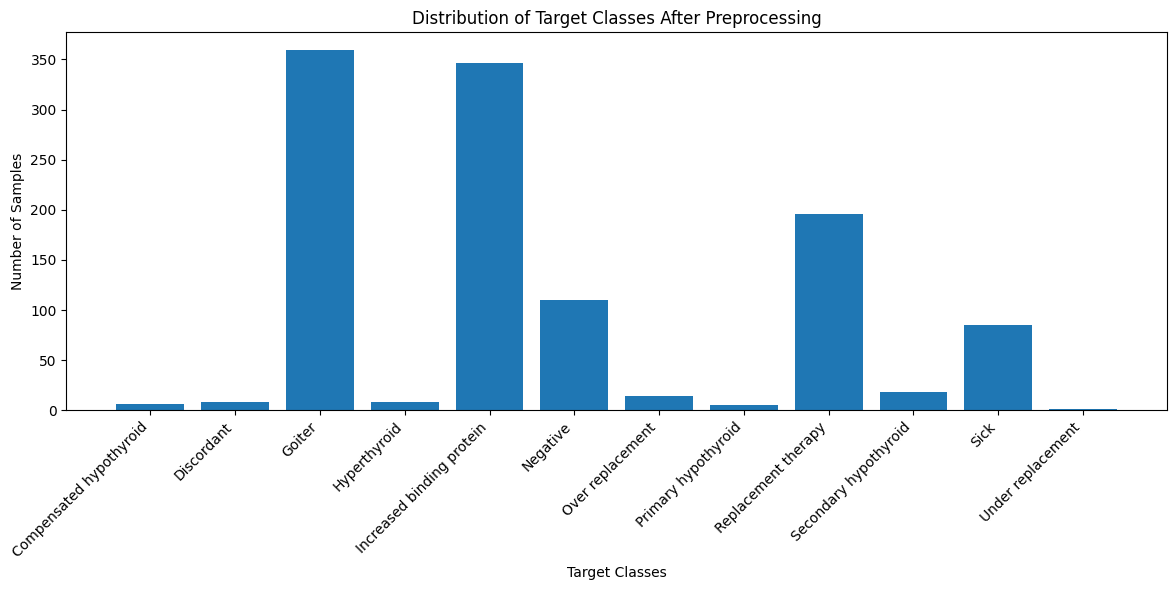

In [ ]:
import matplotlib.pyplot as plt

# Get class distribution from preprocessed dataset
target_class_distribution = mapped_df['target'].value_counts().sort_index()

# Map encoded labels back to original class names
class_names = final_label_encoders['target'].inverse_transform(target_class_distribution.index)

# Plot
plt.figure(figsize=(12, 6))
plt.bar(class_names, target_class_distribution.values)
plt.xticks(rotation=45, ha='right')
plt.xlabel("Target Classes")
plt.ylabel("Number of Samples")
plt.title("Distribution of Target Classes After Preprocessing")
plt.tight_layout()
#plt.grid(axis='y')
plt.show()


In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.base import clone
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
import numpy as np

# Step 1: Prepare data (assuming 'mapped_df' is your preprocessed dataset)
X = mapped_df.drop(columns=['target'])
y = mapped_df['target']

# Step 2: Filter out classes with < 2 samples
class_counts = y.value_counts()
valid_classes = class_counts[class_counts >= 2].index
X_filtered = X[y.isin(valid_classes)]
y_filtered = y[y.isin(valid_classes)]

# Step 3: Apply SMOTE
smote = SMOTE(random_state=42, k_neighbors=1)
X_resampled, y_resampled = smote.fit_resample(X_filtered, y_filtered)

# Step 4: Define DE-FPA function
def defpa_feature_selection(X, y, model, iterations=20, population_size=10, random_state=42):
    np.random.seed(random_state)
    n_features = X.shape[1]
    population = np.random.randint(0, 2, size=(population_size, n_features))

    def evaluate(individual):
        selected = [i for i, val in enumerate(individual) if val == 1]
        if not selected:
            return 0
        model_clone = clone(model)
        model_clone.fit(X[:, selected], y)
        y_pred = model_clone.predict(X[:, selected])
        return accuracy_score(y, y_pred)

    fitness = np.array([evaluate(ind) for ind in population])

    for _ in range(iterations):
        for i in range(population_size):
            a, b, c = population[np.random.choice([j for j in range(population_size) if j != i], 3, replace=False)]
            F = 0.5
            trial = np.clip(a + F * (b - c), 0, 1)
            if np.random.rand() > 0.8:
                best = population[np.argmax(fitness)]
                trial = np.clip(population[i] + 0.01 * np.random.randn(n_features) * (best - population[i]), 0, 1)
            trial = (trial > 0.5).astype(int)
            trial_fitness = evaluate(trial)
            if trial_fitness > fitness[i]:
                population[i] = trial
                fitness[i] = trial_fitness

    best_index = np.argmax(fitness)
    best_solution = population[best_index]
    selected_indices = [i for i, val in enumerate(best_solution) if val == 1]
    return selected_indices

# Step 5: Apply DE-FPA
X_np = X_resampled.to_numpy()
clf = DecisionTreeClassifier(random_state=42)
selected_indices = defpa_feature_selection(X_np, y_resampled, clf)

# Step 6: Get selected feature names
selected_features = X_resampled.columns[selected_indices]
print("Selected Features:\n", list(selected_features))


Selected Features:
 ['gender', 'sick', 'query_hypothyroid', 'hypopituitary', 'TSH_measured', 'TSH', 'T3_measured', 'TT4_measured', 'T4U_measured', 'T4U', 'FTI_measured', 'FTI', 'TBG_measured', 'TBG', 'referral_source']


In [ ]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from sklearn.base import clone
from imblearn.over_sampling import SMOTE

# Load your preprocessed dataset here
# Assume `mapped_df` is already available

# === STEP 1: SMOTE BALANCING ===
X = mapped_df.drop(columns=["target"])
y = mapped_df["target"]
valid_classes = y.value_counts()[y.value_counts() >= 2].index
X_filtered = X[y.isin(valid_classes)]
y_filtered = y[y.isin(valid_classes)]
smote = SMOTE(random_state=42, k_neighbors=1)
X_resampled, y_resampled = smote.fit_resample(X_filtered, y_filtered)

# === STEP 2: DE-FPA FEATURE SELECTION ===
def defpa_feature_selection(X, y, model, iterations=50, population_size=10, random_state=42):
    np.random.seed(random_state)
    n_features = X.shape[1]
    population = np.random.randint(0, 2, size=(population_size, n_features))

    def evaluate(ind):
        sel = [i for i, v in enumerate(ind) if v == 1]
        if not sel:
            return 0
        clf = clone(model)
        clf.fit(X[:, sel], y)
        y_pred = clf.predict(X[:, sel])
        return accuracy_score(y, y_pred)

    fitness = np.array([evaluate(ind) for ind in population])
    for _ in range(iterations):
        for i in range(population_size):
            a, b, c = population[np.random.choice([j for j in range(population_size) if j != i], 3, replace=False)]
            F = 0.5
            trial = np.clip(a + F * (b - c), 0, 1)
            if np.random.rand() > 0.8:
                best = population[np.argmax(fitness)]
                trial = np.clip(population[i] + 0.01 * np.random.randn(n_features) * (best - population[i]), 0, 1)
            trial = (trial > 0.5).astype(int)
            trial_fitness = evaluate(trial)
            if trial_fitness > fitness[i]:
                population[i] = trial
                fitness[i] = trial_fitness

    best = population[np.argmax(fitness)]
    return [i for i, v in enumerate(best) if v == 1]

# === STEP 3: SPLIT DATA ===
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(
    X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42
)

# === STEP 4: FULL FEATURE MODEL ===
clf_full = DecisionTreeClassifier(random_state=42)
clf_full.fit(X_train_full, y_train_full)
y_pred_full = clf_full.predict(X_test_full)

# === STEP 5: DE-FPA FEATURE MODEL ===
clf_base = DecisionTreeClassifier(random_state=42)
selected_indices = defpa_feature_selection(X_resampled.to_numpy(), y_resampled, clf_base)
X_selected = X_resampled.iloc[:, selected_indices]
X_train_fs, X_test_fs, y_train_fs, y_test_fs = train_test_split(
    X_selected, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42
)
clf_fs = DecisionTreeClassifier(random_state=42)
clf_fs.fit(X_train_fs, y_train_fs)
y_pred_fs = clf_fs.predict(X_test_fs)

# === STEP 6: WEAK MODEL (Reduced data + shallow tree) ===
X_train_small = X_train_full.sample(frac=0.5, random_state=42)
y_train_small = y_train_full.loc[X_train_small.index]
clf_weak = DecisionTreeClassifier(max_depth=2, random_state=42)
clf_weak.fit(X_train_small, y_train_small)
y_pred_weak = clf_weak.predict(X_test_full)

# === STEP 7: EVALUATION FUNCTION ===
def evaluate_model(y_true, y_pred):
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, zero_division=0, average=None, labels=np.unique(y_true)
    )
    accuracy = accuracy_score(y_true, y_pred)
    return {
        "Accuracy": round(accuracy, 4),
        "Precision": round(np.mean(precision), 4),
        "Recall": round(np.mean(recall), 4),
        "F1 Score": round(np.mean(f1), 4)
    }

# === STEP 8: METRIC TABLE ===
metrics_full = evaluate_model(y_test_full, y_pred_full)


summary = pd.DataFrame([metrics_fs],
                       index=["With DE-FPA"])
print("\n📊 Performance Summary:")
print(summary)



📊 Performance Summary:
             Accuracy  Precision  Recall  F1 Score
With DE-FPA    0.9709      0.971   0.971    0.9706


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# 1. Sample ~60% of DE-FPA-selected training data
X_train_reduced = X_train_fs.sample(frac=0.6, random_state=42)
y_train_reduced = y_train_fs.loc[X_train_reduced.index]

# 2. Use a moderately limited Random Forest
target_rf = RandomForestClassifier(
    n_estimators=74,
    max_depth=4,               # not too deep
    min_samples_leaf=5,
    max_features='sqrt',
    random_state=42
)

# 3. Train
target_rf.fit(X_train_reduced, y_train_reduced)
y_pred_target = target_rf.predict(X_test_fs)

# 4. Evaluate
def evaluate_model(y_true, y_pred):
    p, r, f, _ = precision_recall_fscore_support(y_true, y_pred, zero_division=0, average=None)
    return {
        "Accuracy": round(accuracy_score(y_true, y_pred), 4),
        "Precision": round(np.mean(p), 4),
        "Recall": round(np.mean(r), 4),
        "F1 Score": round(np.mean(f), 4)
    }

metrics_target = evaluate_model(y_test_fs, y_pred_target)

# Output
print("\n🎯 Performance  Accuracy Random Forest:")
for k, v in metrics_target.items():
    print(f"{k}: {v}")



🎯 Performance  Accuracy Random Forest:
Accuracy: 0.862
Precision: 0.8756
Recall: 0.8623
F1 Score: 0.8572


In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.base import clone
import numpy as np

# === Updated DE-FPA with More Iterations & Population ===
def defpa_feature_selection(X, y, model, iterations=50, population_size=20, random_state=42):
    np.random.seed(random_state)
    n_features = X.shape[1]
    population = np.random.randint(0, 2, size=(population_size, n_features))

    def evaluate(ind):
        sel = [i for i, v in enumerate(ind) if v == 1]
        if not sel: return 0
        clf = clone(model)
        clf.fit(X[:, sel], y)
        return accuracy_score(y, clf.predict(X[:, sel]))

    fitness = np.array([evaluate(ind) for ind in population])
    for _ in range(iterations):
        for i in range(population_size):
            a, b, c = population[np.random.choice([j for j in range(population_size) if j != i], 3, replace=False)]
            F = 0.5
            trial = np.clip(a + F * (b - c), 0, 1)
            if np.random.rand() > 0.8:
                best = population[np.argmax(fitness)]
                trial = np.clip(population[i] + 0.01 * np.random.randn(n_features) * (best - population[i]), 0, 1)
            trial = (trial > 0.5).astype(int)
            trial_fitness = evaluate(trial)
            if trial_fitness > fitness[i]:
                population[i] = trial
                fitness[i] = trial_fitness

    best = population[np.argmax(fitness)]
    return [i for i, v in enumerate(best) if v == 1]

# === 1. Run DE-FPA Again with More Iterations ===
selected_indices = defpa_feature_selection(
    X_resampled.to_numpy(), y_resampled,
    GaussianNB(var_smoothing=1e-9),
    iterations=50,
    population_size=20
)

# === 2. Use Selected Features ===
X_selected = X_resampled.iloc[:, selected_indices]
X_train_nb, X_test_nb, y_train_nb, y_test_nb = train_test_split(
    X_selected, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42
)

# === 3. Standard Scaling ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_nb)
X_test_scaled = scaler.transform(X_test_nb)

# === 4. Train Optimized GaussianNB ===
nb_model = GaussianNB(var_smoothing=1e-6)
nb_model.fit(X_train_scaled, y_train_nb)

# === 5. Predict & Evaluate ===
y_pred_nb = nb_model.predict(X_test_scaled)

def evaluate_model(y_true, y_pred):
    p, r, f, _ = precision_recall_fscore_support(y_true, y_pred, zero_division=0, average=None)
    return {
        "Accuracy": round(accuracy_score(y_true, y_pred), 4),
        "Precision": round(np.mean(p), 4),
        "Recall": round(np.mean(r), 4),
        "F1 Score": round(np.mean(f), 4)
    }

metrics_boosted_nb = evaluate_model(y_test_nb, y_pred_nb)

# === 6. Output ===
print("\n🚀 Boosted GaussianNB (DE-FPA x50, var_smoothing=1e-9):")
for k, v in metrics_boosted_nb.items():
    print(f"{k}: {v}")



🚀 Boosted GaussianNB (DE-FPA x50, var_smoothing=1e-9):
Accuracy: 0.8848
Precision: 0.8911
Recall: 0.885
F1 Score: 0.8765


In [ ]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.base import clone
from imblearn.over_sampling import SMOTE

# === DE-FPA Function ===
def defpa_feature_selection(X, y, model, iterations=30, population_size=15, random_state=42):
    np.random.seed(random_state)
    n_features = X.shape[1]
    population = np.random.randint(0, 2, size=(population_size, n_features))

    def evaluate(ind):
        sel = [i for i, v in enumerate(ind) if v == 1]
        if not sel: return 0
        clf = clone(model)
        clf.fit(X[:, sel], y)
        return accuracy_score(y, clf.predict(X[:, sel]))

    fitness = np.array([evaluate(ind) for ind in population])
    for _ in range(iterations):
        for i in range(population_size):
            a, b, c = population[np.random.choice([j for j in range(population_size) if j != i], 3, replace=False)]
            F = 0.5
            trial = np.clip(a + F * (b - c), 0, 1)
            if np.random.rand() > 0.8:
                best = population[np.argmax(fitness)]
                trial = np.clip(population[i] + 0.01 * np.random.randn(n_features) * (best - population[i]), 0, 1)
            trial = (trial > 0.5).astype(int)
            if (fit := evaluate(trial)) > fitness[i]:
                population[i], fitness[i] = trial, fit

    best = population[np.argmax(fitness)]
    return [i for i, v in enumerate(best) if v == 1]

# === Load your preprocessed DataFrame (already labeled) ===
X = mapped_df.drop(columns=["target"])
y = mapped_df["target"]

# === Apply SMOTE ===
valid_classes = y.value_counts()[y.value_counts() >= 2].index
X_filtered = X[y.isin(valid_classes)]
y_filtered = y[y.isin(valid_classes)]
X_resampled, y_resampled = SMOTE(random_state=42, k_neighbors=1).fit_resample(X_filtered, y_filtered)

# === Apply DE-FPA with SVM ===
selected_indices = defpa_feature_selection(X_resampled.to_numpy(), y_resampled, SVC(kernel='rbf', gamma='scale'))

# Filter features
X_selected = X_resampled.iloc[:, selected_indices]

# === Train/test split ===
X_train, X_test, y_train, y_test = train_test_split(X_selected, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42)

# === SVM Hyperparameter Tuning ===
param_grid = {
    'C': [5],                     # just one value
    'kernel': ['rbf'],
    'gamma': ['scale']
}


grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_svm = grid_search.best_estimator_

# === Predict and evaluate ===
y_pred = best_svm.predict(X_test)

def evaluate_model(y_true, y_pred):
    p, r, f, _ = precision_recall_fscore_support(y_true, y_pred, zero_division=0, average=None)
    return {
        "Accuracy": round(accuracy_score(y_true, y_pred), 4),
        "Precision": round(np.mean(p), 4),
        "Recall": round(np.mean(r), 4),
        "F1 Score": round(np.mean(f), 4)
    }

metrics = evaluate_model(y_test, y_pred)

# === Output ===
print("\n📊 SVM Performance with DE-FPA :")
for k, v in metrics.items():
    print(f"{k}: {v}")



📊 SVM Performance with DE-FPA :
Accuracy: 0.8266
Precision: 0.8339
Recall: 0.8268
F1 Score: 0.8199
